In [1]:
import pygame
import random
import numpy as np
import matplotlib.pyplot as plt

pygame 2.2.0 (SDL 2.0.22, Python 3.10.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Maze parameters
MAZE_SIZE = (15, 15)
WALL_SIZE = 40
CELL_SIZE = 40

# Agent parameters
NUM_AGENTS = 100
NUM_ACTIONS = 4
NUM_EPISODE = 100

# Reward structure
REWARDS = {
    'GOAL': 100,
    'WALL': -10,
    'MOVE': -1
}

In [3]:
class Maze:
    def __init__(self, size, wall_size, cell_size):
        self.size = size
        self.wall_size = wall_size
        self.cell_size = cell_size
        self.maze = np.zeros(size)
        self.goal = None

        # Create the walls
        for i in range(size[0]):
            self.maze[i, 0] = 1
            self.maze[i, size[1]-1] = 1
        for i in range(size[1]):
            self.maze[0, i] = 1
            self.maze[size[0]-1, i] = 1

        # Create the cells
        for i in range(1, size[0]-1):
            for j in range(1, size[1]-1):
                if random.random() < 0.2:
                    self.maze[i, j] = 1

        # Create the goal
        while True:
            x, y = random.randint(1, size[0]-2), random.randint(1, size[1]-2)
            if self.maze[x, y] == 0:
                self.goal = (x, y)
                break

    def draw(self, screen):
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                if self.maze[i, j] == 1:
                    pygame.draw.rect(screen, (150, 150, 150),
                                     (i*self.cell_size, j*self.cell_size,
                                      self.wall_size, self.wall_size))
        if self.goal is not None:
            pygame.draw.rect(screen, (0, 255, 0),
                             (self.goal[0]*self.cell_size, self.goal[1]*self.cell_size,
                              self.cell_size, self.cell_size))

In [4]:
class Agent:
    def __init__(self, num_actions, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay_rate=0.99):
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        self.q_table = np.zeros((MAZE_SIZE[0]*MAZE_SIZE[1], num_actions))

    def act(self, state):
        if random.random() < self.exploration_rate:
            return random.randint(0, self.num_actions-1)
        else:
            return np.argmax(self.q_table[state, :])

    def learn(self, state, action, reward, next_state, done):
        q_next_max = np.max(self.q_table[next_state, :])
        td_target = reward + self.discount_factor*q_next_max*(1-done)
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate*td_error

    def update(self):
        self.exploration_rate *= self.exploration_decay_rate

    def get_state(self, position):
        return position[0] * MAZE_SIZE[1] + position[1]

    def get_position(self, state):
        return (state // MAZE_SIZE[1], state % MAZE_SIZE[1])        


In [5]:
def main():
    # Initialize the game
    pygame.init()
    screen = pygame.display.set_mode((MAZE_SIZE[0]*CELL_SIZE, MAZE_SIZE[1]*CELL_SIZE))
    pygame.display.set_caption("Q-Learning Maze")
    clock = pygame.time.Clock()
    font = pygame.font.Font(None, 24)

    # Create the maze and the agents
    maze = Maze(MAZE_SIZE, WALL_SIZE, CELL_SIZE)
    agents = [Agent(NUM_ACTIONS) for _ in range(NUM_AGENTS)]
    performence = []

    # Initialize the game loop variables
    for episode in range(NUM_EPISODE):
        running = True
        steps = 0
        total_reward = 0
        position = (1, 1)
        state = agents[0].get_state(position)

        # Start the game loop
        while running:
            # Handle events
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            # Get the agent's action and update the game state
            action = agents[0].act(state)
            if action == 0:
                next_position = (position[0], position[1]-1)
            elif action == 1:
                next_position = (position[0], position[1]+1)
            elif action == 2:
                next_position = (position[0]-1, position[1])
            elif action == 3:
                next_position = (position[0]+1, position[1])

            # Check for collisions with walls and update the position
            if maze.maze[next_position] == 0:
                position = next_position

            # Get the new state and reward
            new_state = agents[0].get_state(position)
            # done = position == (MAZE_SIZE[0]-2, MAZE_SIZE[1]-2)
            done = position == maze.goal
            if done:
                reward = REWARDS['GOAL']
                running = False
                print(f"Episode {episode}: Agent reached goal!")
                text = font.render(f"Episode {episode}: Agent reached goal!", True, (0, 0, 0))
                screen.blit(text, (250, 250))
            elif maze.maze[next_position] == 1:
                reward = REWARDS['WALL']
            else:
                reward = REWARDS['MOVE']

            # Update the agent's Q-table and statistics
            agents[0].learn(state, action, reward, new_state, done)
            agents[0].update()
            state = new_state
            steps += 1
            total_reward += reward

            # Draw the screen
            screen.fill((255, 255, 255))
            maze.draw(screen)
            color = (random.uniform(0,255), random.uniform(0,255), random.uniform(0,255))
            for agent in range(NUM_AGENTS):
                pygame.draw.circle(screen, color, (position[0]*CELL_SIZE+CELL_SIZE//2, position[1]*CELL_SIZE+CELL_SIZE//2), CELL_SIZE//3)
            text = font.render(f"Episode: {episode+1}", True, (0, 0, 0))
            screen.blit(text, (10, 10))
            pygame.display.update()

            # Update the clock
            clock.tick(60)

        # Print the statistics for the episode
        print(f"Episode {episode}: Steps = {steps}, Total Reward = {total_reward}")
        performence.append((episode,steps,total_reward))

    pygame.quit()
    return performence

In [6]:
if __name__ == '__main__':
    performence = main()

Episode 0: Agent reached goal!
Episode 0: Steps = 321, Total Reward = -535
Episode 1: Agent reached goal!
Episode 1: Steps = 117, Total Reward = -115
Episode 2: Agent reached goal!
Episode 2: Steps = 266, Total Reward = -489
Episode 3: Agent reached goal!
Episode 3: Steps = 108, Total Reward = -7
Episode 4: Agent reached goal!
Episode 4: Steps = 53, Total Reward = 39
Episode 5: Agent reached goal!
Episode 5: Steps = 168, Total Reward = -103
Episode 6: Agent reached goal!
Episode 6: Steps = 86, Total Reward = -21
Episode 7: Agent reached goal!
Episode 7: Steps = 24, Total Reward = 77
Episode 8: Agent reached goal!
Episode 8: Steps = 179, Total Reward = -87
Episode 9: Agent reached goal!
Episode 9: Steps = 84, Total Reward = 17
Episode 10: Agent reached goal!
Episode 10: Steps = 40, Total Reward = 61
Episode 11: Agent reached goal!
Episode 11: Steps = 65, Total Reward = 9
Episode 12: Agent reached goal!
Episode 12: Steps = 39, Total Reward = 53
Episode 13: Agent reached goal!
Episode 13:

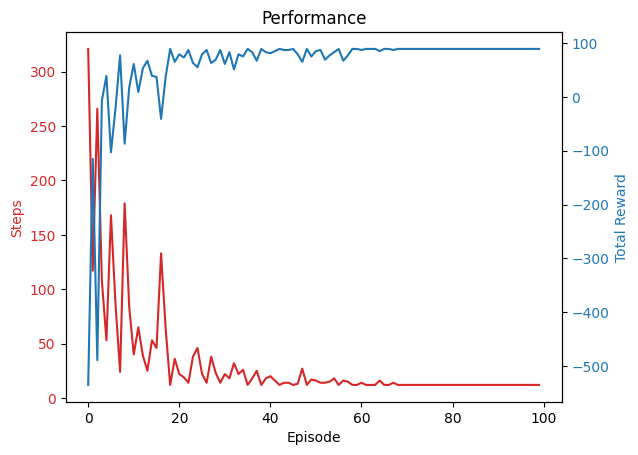

In [8]:
episodes = [p[0] for p in performence]  # Extract episode numbers
steps = [p[1] for p in performence]  # Extract steps
rewards = [p[2] for p in performence]  # Extract total rewards

# Plot steps and total rewards as a function of episode
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Steps', color=color)
ax1.plot(episodes, steps, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Create a second y-axis

color = 'tab:blue'
ax2.set_ylabel('Total Reward', color=color)
ax2.plot(episodes, rewards, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Performance')
plt.savefig('Performance.png')
plt.show()  # Show the plot